In [1]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

# Params

In [2]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 60
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [3]:
def month(data):
    data_reset = data.reset_index()
    data_reset = data_reset.set_index('date')
    data_monthly = data_reset.groupby('permno').resample('M').last()
    data_monthly = data_monthly.reset_index(0, drop=True)
    data_monthly = data_monthly.reset_index()
    data_monthly = data_monthly.set_index(['permno', 'date'])
    return data_monthly

In [4]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = fund_q.groupby('permno').shift(3)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

# Factors

### Value

In [5]:
# Create Book-to-Earnings Ratio
fund_q['btm'] = fund_q['ceqq']/(fund_q['cshoq']*fund_q['prccq'])
btm = fund_q[['btm']]

### Momentum

In [6]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

In [7]:
def calculate_rolling_momentum(stock_data):
    # Calculate excess return
    stock_data['excess_return'] = stock_data['RET_01'] - stock_data['RF']

    # Calculate the 12-month rolling cumulative excess return, excluding the most recent month
    shifted_excess_return = stock_data['excess_return'].shift(1)
    rolling_momentum = shifted_excess_return.rolling(window=21).sum()

    return rolling_momentum

In [8]:
# Create momentum weights
rf_df = create_multi_index(rf, stock)
mom = price.merge(rf_df, left_index=True, right_index=True, how='left').ffill()
mom = create_return(mom, [1])

In [9]:
# Calculate rolling momentum for each stock
mom['mom'] = mom.groupby(level='permno').apply(calculate_rolling_momentum).reset_index(level=0, drop=True)

### Defensive

In [10]:
# Create defensive beta weights
# Read in SPY data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=current_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
spy_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_spy = spy.columns

spy_data = create_return(spy_data, T)
spy_data = spy_data.fillna(0)

# Execute Rolling LR
beta_spy = rolling_ols_parallel(data=spy_data, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05ticker/s]


In [11]:
defense = beta_spy[[f'SPY_RET_01_spy_01_{window}']]
defense.columns = ['beta']

# Setting Up Data

In [12]:
factor = pd.merge(mom, btm, left_index=True, right_index=True, how='left').merge(defense, left_index=True, right_index=True, how='left')

In [13]:
# Add market_cap
market = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
factor = factor.merge(market, left_index=True, right_index=True, how='left')
# Shift Returns back 1
factor['RET_01'] = factor.groupby('permno')['RET_01'].shift(-1)

# Factor Portfolios

In [66]:
# Function to select top and bottom stocks
def select_long_short_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1

    # top_stocks['final_weight'] = top_stocks['adj_weight'] / top_stocks['adj_weight'].abs().sum()
    # bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] / bottom_stocks['adj_weight'].abs().sum()
    # top_stocks['final_weight'] *= 0.5
    # bottom_stocks['final_weight'] *= -0.5
    return pd.concat([top_stocks, bottom_stocks])

# Create Factor-Based Portfolio
def create_factor_port(data, factors, threshold):
    df = data.copy(deep=True)
    # Filtering by Market Capitalization
    df = df[df['market_cap'] >= threshold]
    # Create ranks for each factor
    print("-"*60)
    print("Creating Factor Ranks...")
    for factor_name in factors:
        print(f'Factor: {factor_name}')
        df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank(ascending=False)
    # Calculating average rank
    df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)
    # Calculating rank weights
    df['rank_weight'] = (1 / len(factors)) * df['avg_rank']
    # Calculating inverse volatility
    df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
    df['inv_vol_weight'] = 1 / df['vol']
    # Find adjusted weight that accounts for rank and inverse volatility
    df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']
    # Selecting Top and Bottom Stocks
    print("-"*60)
    print("Creating Long/Short portfolio...")
    long_short_stocks = df.groupby('date').apply(select_long_short_stocks).reset_index(level=0, drop=True)
    # Normalizing Weights
    long_short_stocks['final_weight'] /= long_short_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())
    long_short_stocks['total_ret'] = long_short_stocks['RET_01'] * long_short_stocks['final_weight']
    total_ret = long_short_stocks.groupby('date').total_ret.sum()
    qs.reports.full(total_ret, 'SPY')
    return total_ret, long_short_stocks

------------------------------------------------------------
Creating Factor Ranks...
Factor: mom
Factor: btm
Factor: beta
------------------------------------------------------------
Creating Long/Short portfolio...
[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-03-01   2005-03-01
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          265.26%      237.4%
CAGR﹪                     4.9%         4.59%

Sharpe                     0.45         0.89
Prob. Sharpe Ratio         97.48%       99.99%
Smart Sharpe               0.44         0.86
Sortino                    0.64         1.24
Smart Sortino              0.61         1.2
Sortino/√2                 0.45         0.88
Smart Sortino/√2           0.43         0.85
Omega                      1.18         1.18

Max Drawdown               -56.47%      -33.21%
Longest DD Days            1982         1602
Volatility (ann.)          19.47%       7.65%
R^2                        0.01         0.01
Information Ratio          -0.01        -0.01
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-06-01,2009-03-10,2011-10-19,1602,-33.207685,-30.432708
2,2020-02-18,2020-03-20,2020-05-27,100,-15.309019,-14.022944
3,2005-03-04,2006-02-06,2007-04-18,776,-12.136264,-11.824048
4,2022-04-21,2022-06-15,2022-07-26,97,-6.389857,-6.316789
5,2022-12-02,2023-03-22,2023-04-25,145,-6.387114,-6.238625


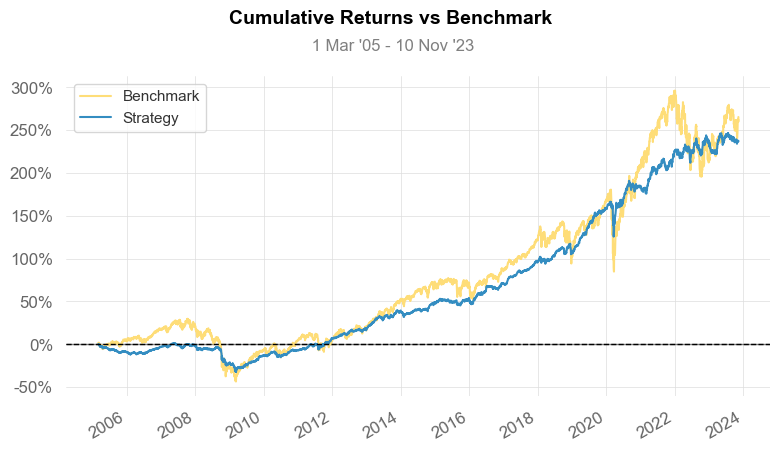

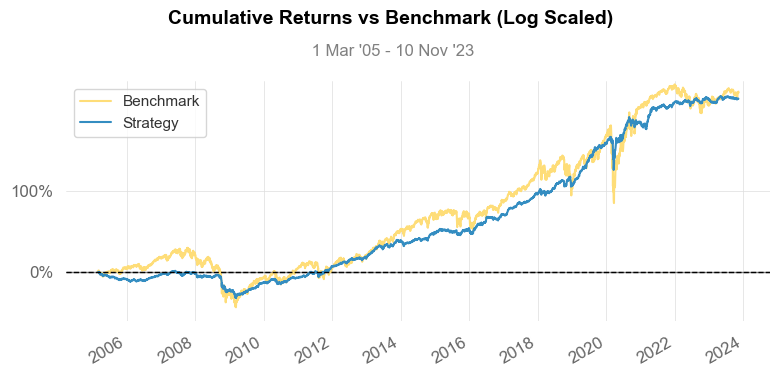

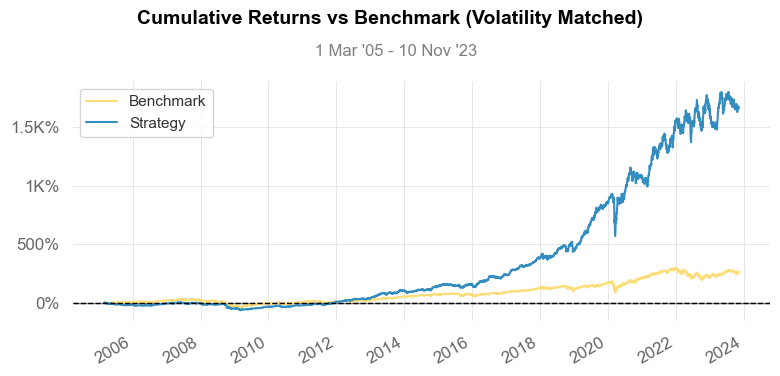

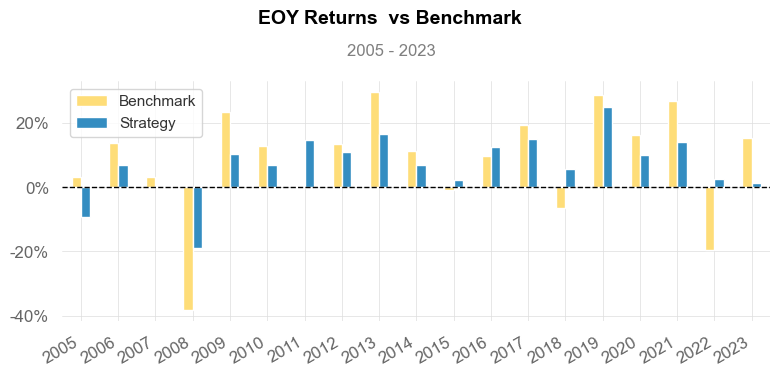

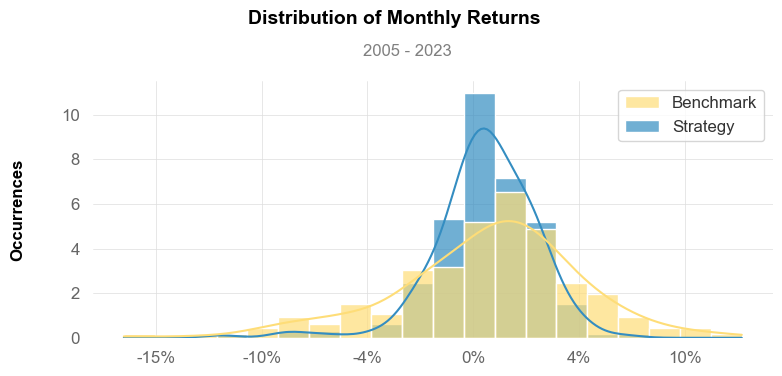

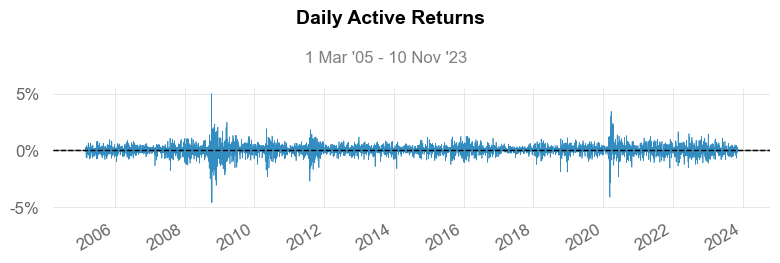

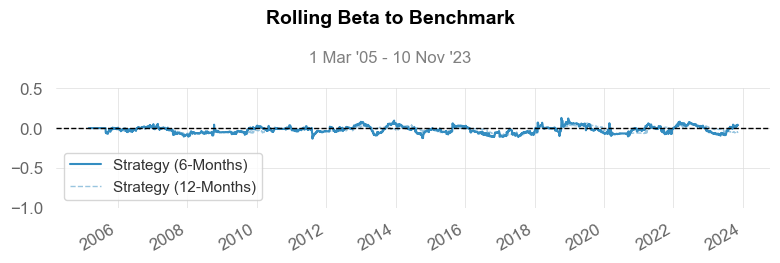

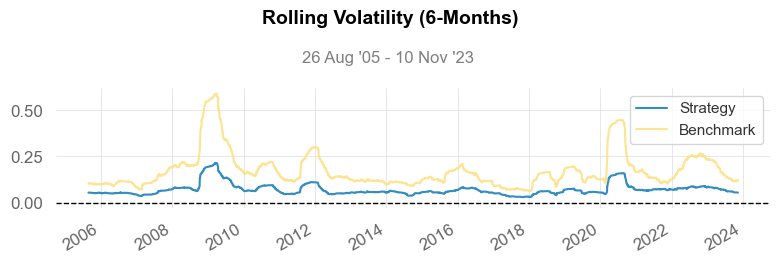

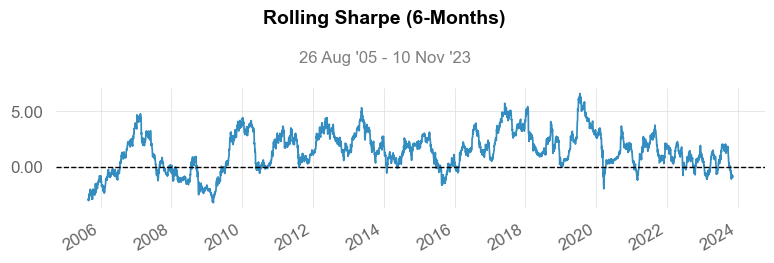

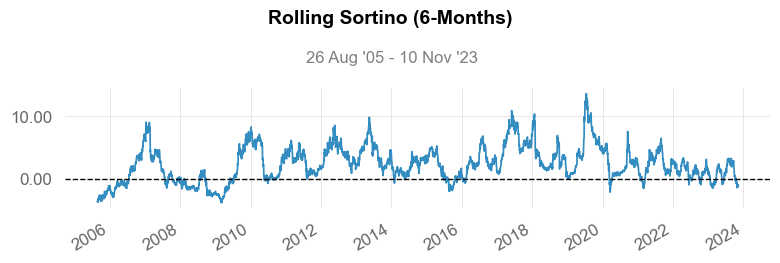

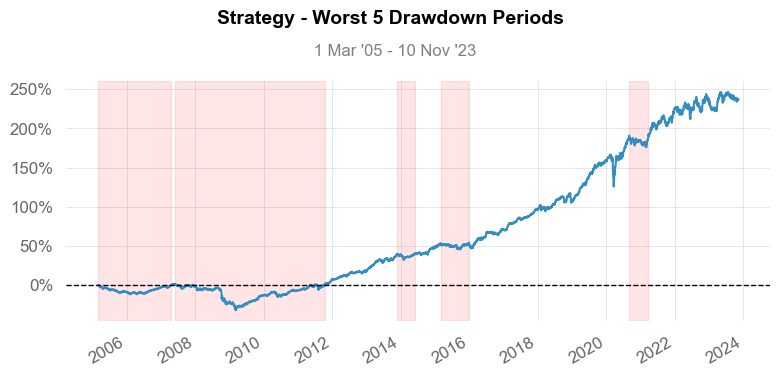

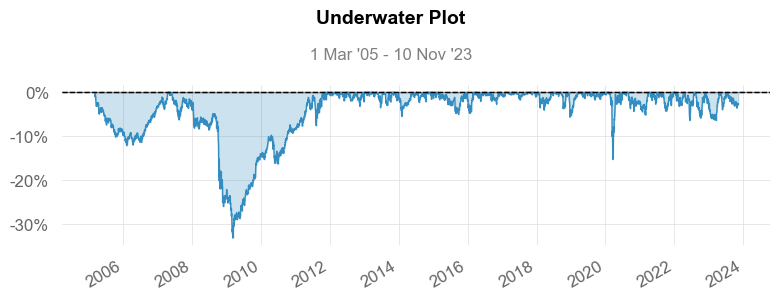

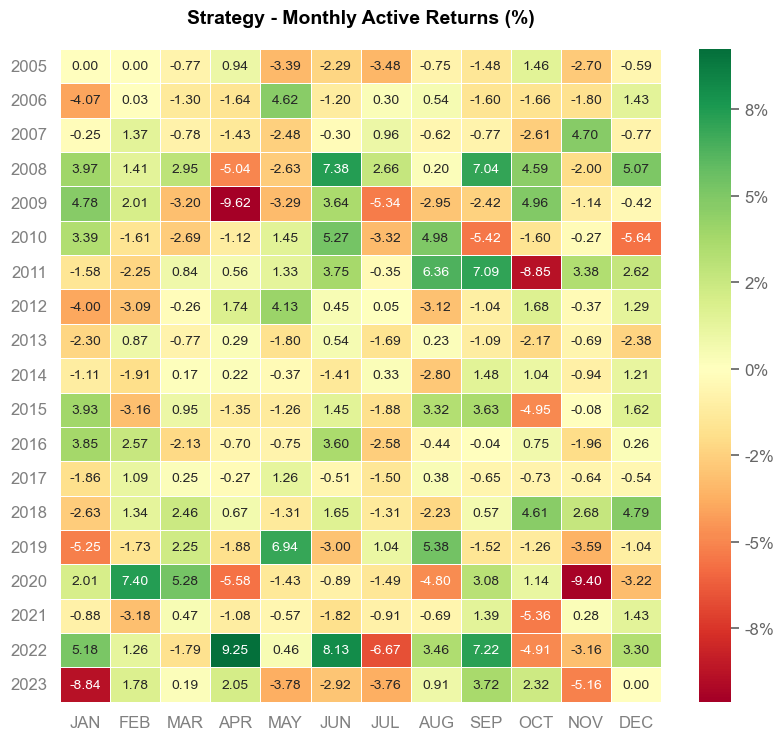

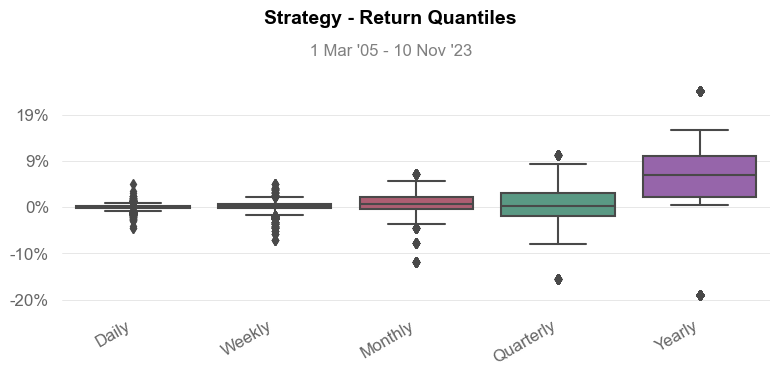

In [94]:
factors = ['mom', 'btm', 'beta']

total_ret, long_short_stocks = create_factor_port(factor, factors, threshold)

# Minimizing Market Exposure

In [95]:
def mfl(data, stocks_to_use, col_name, exp, min_exp_weights, alpha, lambda_reg):
    def objective_cvxpy(weights, ret, betas, min_exp_weights, alpha, lambda_reg):
        # Initialize the alternative objective
        factor_exposure  = 0.0
        # Loop through each factor and calculate its contribution to the objective
        for factor, weight in min_exp_weights.items():
            port_beta = cp.matmul(weights, betas[factor])
            factor_exposure += weight * cp.square(port_beta)
            
        l2_reg = cp.norm(weights, 2)**2
        port_ret = cp.matmul(weights, ret)
        # return factor_exposure + lambda_reg * l2_reg
        return factor_exposure - port_ret * alpha + lambda_reg * l2_reg

    collect_weight = []
    count = 0 
    print(f'Processing {type}...')
    for date, row in stocks_to_use.iterrows():
        stocks = stocks_to_use.loc[stocks_to_use.index == date][col_name][0]
        # Get betas for given stocks at day t
        betas = exp.loc[exp.index.get_level_values('date') == date]
        betas = get_stocks_data(betas, stocks)
        betas = betas.fillna(0)
        # Get returns for given stocks at day t
        ret = data.loc[data.index.get_level_values('date') == date][['RET_01_expected']]
        ret = get_stocks_data(ret, stocks)

        # CVXPY setup
        weights = cp.Variable(betas.shape[0])
        objective = cp.Minimize(objective_cvxpy(weights, ret, betas, min_exp_weights, alpha, lambda_reg))
        constraints = [
            cp.sum(weights) == 1,
            weights >= 0.001,
            weights <= 0.10
        ]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver='SCS')
        collect_weight.append(weights.value)
        
        # Track performance
        if count % 30 == 0:
            print(date)
        count += 1
    
    return collect_weight

In [96]:
def create_stock_list_df(data):
    permno_per_date = []
    date_unique = data.index.get_level_values('date').unique()
    for date_group in date_unique:
        stocks = data.loc[data.index.get_level_values('date') == date_group].index.get_level_values('permno')
        permno_per_date.append(stocks.values.tolist())
    
    stocks_to_use = pd.DataFrame(index=date_unique) 
    stocks_to_use['stock'] = permno_per_date
    return stocks_to_use

In [97]:
# Expected Return
long_short_stocks['RET_01_expected'] = long_short_stocks.groupby('permno')['RET_01'].shift(1)
long_short_stocks = set_timeframe(long_short_stocks, '2008-01-01', '2023-01-01')

In [98]:
long_short_permnos = create_stock_list_df(long_short_stocks)

In [99]:
long_short_permnos['long'] = long_short_permnos['stock'].apply(lambda x: x[:25])
long_short_permnos['short'] = long_short_permnos['stock'].apply(lambda x: x[25:])

In [100]:
sb_sector = PrepFactor(live=live, factor_name='factor_sb_sector', group='permno', interval='D', kind='price', stock=stock, div=False, start=start, end=current_date, save=False).prep()

Creating factor_sb_sector ---------------------------------- | ✔
Shape: (3104852, 32)


In [101]:
factor_col = f'SPY_RET_01_spy_01_{window}'
exp = beta_spy[[factor_col]]
min_exp_weights = {
     f'SPY_RET_01_spy_01_{window}' : 1.0
}

factor_col = ['XLB_RET_01_sector_01_126', 'XLE_RET_01_sector_01_126', 'XLF_RET_01_sector_01_126', 'XLI_RET_01_sector_01_126',
              'XLK_RET_01_sector_01_126', 'XLP_RET_01_sector_01_126', 'XLU_RET_01_sector_01_126', 'XLV_RET_01_sector_01_126',
              'XLY_RET_01_sector_01_126']
exp = sb_sector[factor_col]
min_exp_weights = {
    'XLB_RET_01_sector_01_126': 1,
    'XLE_RET_01_sector_01_126': 1,
    'XLF_RET_01_sector_01_126': 1,
    'XLI_RET_01_sector_01_126': 1,
    'XLK_RET_01_sector_01_126': 1,
    'XLP_RET_01_sector_01_126': 1,
    'XLU_RET_01_sector_01_126': 1,
    'XLV_RET_01_sector_01_126': 1,
    'XLY_RET_01_sector_01_126': 1
}
alpha = 0.5
lambda_reg = 1

In [102]:
test = set_timeframe(long_short_permnos, '2009-01-01', '2010-01-01')

In [ ]:
long_min_weights = mfl(data=long_short_stocks, stocks_to_use=long_short_permnos, col_name='long', exp=exp, min_exp_weights=min_exp_weights, alpha=alpha, lambda_reg=lambda_reg)

Processing <class 'type'>...
2008-01-02 00:00:00
2008-02-14 00:00:00
2008-03-31 00:00:00
2008-05-12 00:00:00
2008-06-24 00:00:00
2008-08-06 00:00:00
2008-09-18 00:00:00
2008-10-30 00:00:00
2008-12-12 00:00:00
2009-01-28 00:00:00
2009-03-12 00:00:00
2009-04-24 00:00:00
2009-06-08 00:00:00
2009-07-21 00:00:00
2009-09-01 00:00:00
2009-10-14 00:00:00
2009-11-25 00:00:00
2010-01-11 00:00:00
2010-02-24 00:00:00
2010-04-08 00:00:00
2010-05-20 00:00:00
2010-07-02 00:00:00
2010-08-16 00:00:00
2010-09-28 00:00:00
2010-11-09 00:00:00
2010-12-22 00:00:00
2011-02-04 00:00:00
2011-03-21 00:00:00
2011-05-03 00:00:00
2011-06-15 00:00:00
2011-07-28 00:00:00
2011-09-09 00:00:00
2011-10-21 00:00:00
2011-12-05 00:00:00
2012-01-19 00:00:00
2012-03-02 00:00:00
2012-04-16 00:00:00
2012-05-29 00:00:00
2012-07-11 00:00:00
2012-08-22 00:00:00
2012-10-04 00:00:00
2012-11-19 00:00:00
2013-01-03 00:00:00
2013-02-15 00:00:00
2013-04-02 00:00:00
2013-05-14 00:00:00
2013-06-26 00:00:00
2013-08-08 00:00:00
2013-09-20 

In [25]:
short_min_weights = mfl(data=long_short_stocks, stocks_to_use=long_short_permnos, col_name='short', exp=exp, min_exp_weights=min_exp_weights, alpha=alpha, lambda_reg=lambda_reg)

Processing <class 'type'>...
2008-01-02 00:00:00
2008-02-14 00:00:00
2008-03-31 00:00:00
2008-05-12 00:00:00
2008-06-24 00:00:00
2008-08-06 00:00:00
2008-09-18 00:00:00
2008-10-30 00:00:00
2008-12-12 00:00:00
2009-01-28 00:00:00
2009-03-12 00:00:00
2009-04-24 00:00:00
2009-06-08 00:00:00
2009-07-21 00:00:00
2009-09-01 00:00:00
2009-10-14 00:00:00
2009-11-25 00:00:00
2010-01-11 00:00:00
2010-02-24 00:00:00
2010-04-08 00:00:00
2010-05-20 00:00:00
2010-07-02 00:00:00
2010-08-16 00:00:00
2010-09-28 00:00:00
2010-11-09 00:00:00
2010-12-22 00:00:00
2011-02-04 00:00:00
2011-03-21 00:00:00
2011-05-03 00:00:00
2011-06-15 00:00:00
2011-07-28 00:00:00
2011-09-09 00:00:00
2011-10-21 00:00:00
2011-12-05 00:00:00
2012-01-19 00:00:00
2012-03-02 00:00:00
2012-04-16 00:00:00
2012-05-29 00:00:00
2012-07-11 00:00:00
2012-08-22 00:00:00
2012-10-04 00:00:00
2012-11-19 00:00:00
2013-01-03 00:00:00
2013-02-15 00:00:00
2013-04-02 00:00:00
2013-05-14 00:00:00
2013-06-26 00:00:00
2013-08-08 00:00:00
2013-09-20 

In [ ]:
long_stocks = long_short_stocks.groupby(level='date').head(25)
short_stocks = long_short_stocks.groupby(level='date').tail(-25)

In [ ]:
def calc_min_ret(data, weight, type):
    flattened_array = np.concatenate(weight).flatten()
    flattened_weight = flattened_array.tolist()
    new_exposure = data.copy(deep=True)
    new_exposure['exp_weight'] = flattened_weight
    if type == 'long':
        new_exposure['total_ret'] = new_exposure['RET_01'] * new_exposure['exp_weight'] * 1
    elif type == 'short':
        new_exposure['total_ret'] = new_exposure['RET_01'] * new_exposure['exp_weight'] * -1
    total_ret = new_exposure.groupby('date').total_ret.sum()
    return new_exposure, total_ret

In [ ]:
long_df, long_ret = calc_min_ret(long_stocks[['RET_01']], long_min_weights, 'long')

In [ ]:
short_df, short_ret = calc_min_ret(short_stocks[['RET_01']], short_min_weights, 'short')

In [ ]:
total_ret = 0.5 * long_ret + 0.5 * short_ret

In [ ]:
inv_long = long_stocks.groupby('date').total_ret.sum()

In [ ]:
qs.reports.full(long_ret, 'SPY')